# transformer

transformer を pytorch で実装する。([参照](https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec))

In [1]:
import math
import torch
from torch import nn
from torch.autograd import Variable

## Embedding

In [2]:
class Embedder(nn.Module):
    
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        
    def forward(self, x):
        return self.embed(x)

## Positional encoding

単純な方法では、問題が起こる。([参照](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/))


### 単純な方法１: 最初の token を 0, 最後の token を 1 にする。

token の数の違いによって、間隔が変わってします。10 token の間隔は 0.1 で、20 token の間隔は 0.05 になる。これだと、1 番目と 2 番目の token の「遠さ」が input 依存してしまう。


### 単純な方法２：順番に、1, 2, 3, としていく。

数が大きくなることと、train data の最大 token 数を超える test data が入ってきたときに困る。


### Ideally, the following criteria should be satisfied:

- It should output a unique encoding for each time-step (word’s position in a sentence)
- Distance between any two time-steps should be consistent across sentences with different lengths.
- Our model should generalize to longer sentences without any efforts. Its values should be bounded.
- It must be deterministic.


### 提案手法

$$
\text{PE}_{(pos, 2i)} = \sin(pos / 10000^{2i / d_\text{model}})
$$
$$
\text{PE}_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_\text{model}})
$$

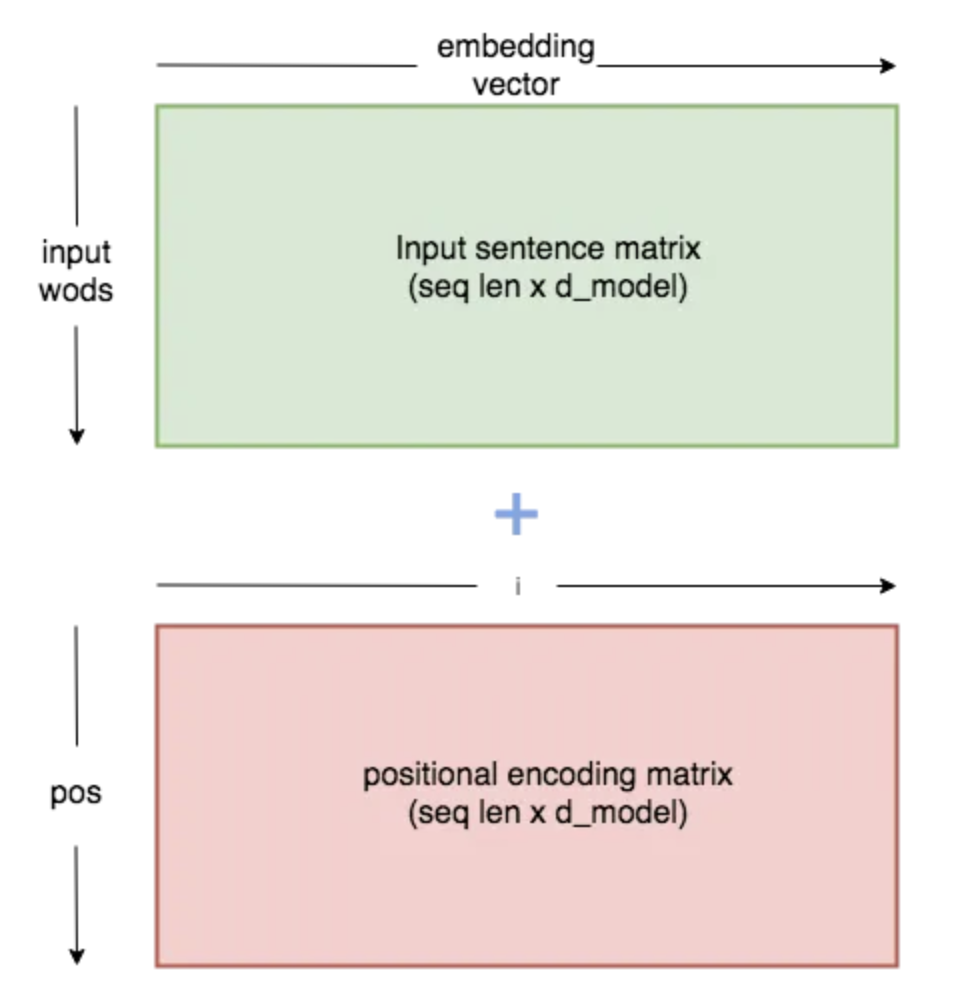

In [3]:
class PositionalEncoder(nn.Module):

    def __init__(self, d_model, max_seq_len=80):  # max_seq_len: maximum token number
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        pe = _get_pe(max_seq_len, d_model)
        self.register_buffer('pe', pe)  # do not optimize during learning
        
    def forward(self, x):
        x = x * math.sqrt(self.d_model)
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False).cuda()
        return x
        

def _get_pe(max_seq_len, d_model):
    pe = torch.zeros(max_seq_len, d_model)
    for pos in range(max_seq_len):
        for i in range(0, d_model, 2):
            pe[pos, i] = math.sin(pos / 10000**((2*i)/d_model))
            pe[pos, i+1] = math.cos(pos / 10000**((2*(i+1))/d_model))
    pe = pe.unsqueeze(0)  # add new axis at the begining of the matrix
    return pe

## Multi-Headed Atteiniton

In [4]:
a = nn.Linear(2, 3)
b = torch.Tensor([[1,2]])
print(b.shape)
a(b)

torch.Size([1, 2])


tensor([[-0.5219, -0.0809, -1.9233]], grad_fn=<AddmmBackward0>)

In [5]:
class MultiHeadAttention(nn.Module):

    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
        
    def forward(self, q, k, v, mask=None):  # shape q, k, v: (bs, seq_len, d_mode)
        bs = q.size(0)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)  # (bs, seq_len, h, d_k)
        q = self.q_linear(k).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(k).view(bs, -1, self.h, self.d_k)
        k = k.transpose(1, 2)  # (bs, h, seq_len, d_k)
        q = q.transpose(1, 2)
        v = v.transpose(1, 2)
        scores = attention(q, k, v, self.d_k, mask, self.dropout)  # (bs, h, seq_len ,d_k)
        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)  # (bs, seq_len, h, d_k) -> (bs, seq_len, d_model)
        output = self.out(concat)
        return output
    

def attnetion(q, k, v, d_k, mask=None, dropout=None):
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)  # matmul((bs, h, seq_len, d_k) x (bs, h, d_k, seq_len)) -> (bs, h, seq_len, seq_len)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill_(mask==0, -1e9)
    scores = nn.functional.softmax(scores, dim=-1)
    if dropout is not None:
        scores = dropout(scores)
    output = torch.matmul(scores, v)  # (bs, h, seq_len, seq_len) x (bs, h, seq_len, d_k) -> (bs, h, seq_len, d_k)
    return output

## Feed-Forward Network

In [6]:
class FeedForward(nn.Module):
    
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        x = self.dropout(nn.functional.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

## Normalization

In [7]:
class Norm(nn.Module):
    
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.size = d_model
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
        
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
                 / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

## Putting it all together!

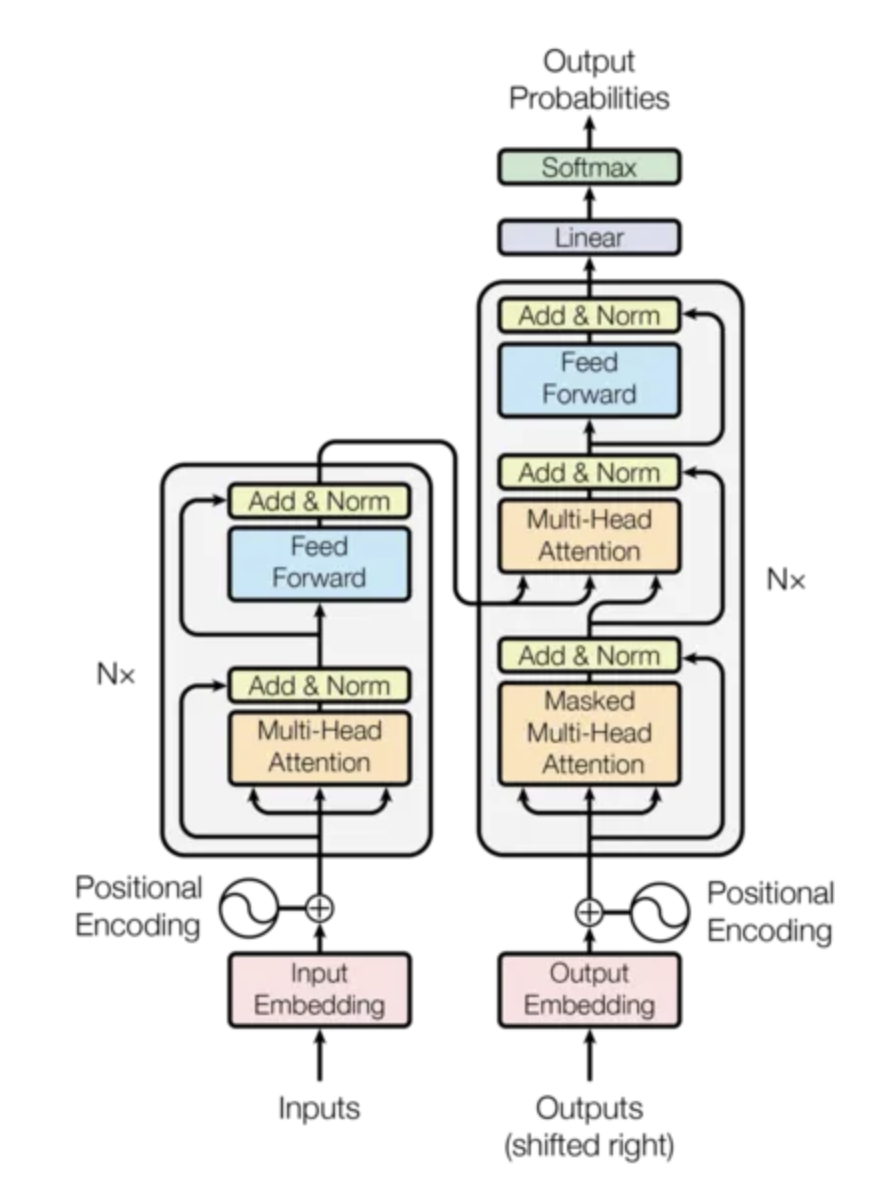

In [8]:
# build an encoder layer with one multi-head attention layer and one # feed-forward layer

class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x
    
# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model).cuda()
def forward(self, x, e_outputs, src_mask, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs,
        src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x
# We can then build a convenient cloning function that can generate multiple layers:

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [9]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

In [10]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output
# we don't perform softmax on the output as this will be handled 
# automatically by our loss function